<a href="https://colab.research.google.com/github/chrisardo/Ejercicios-desarrollados-en-Sql-/blob/main/SESI%C3%93N_2_PROCEDIMIENTOS_ALMACENADOS_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

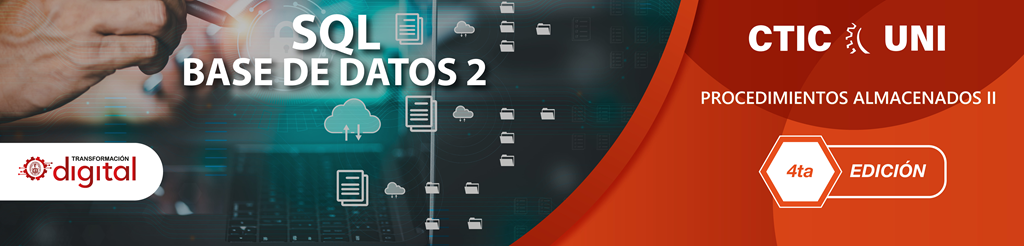

<table border=1 width='99%'>
<tr>
<td bgcolor='#AC2B24'>

# **<font color="#FFFFFF"> PROCEDIMIENTOS ALMACENADOS TRANSACCIONALES</font>**
</td>
</tr>
</table>

Un proceso almacenado transaccional en SQL Server 2022 es un conjunto de instrucciones SQL que se agrupan y se almacenan en la base de datos.

Estos procesos se pueden ejecutar en respuesta a una llamada desde una aplicación o desde otro procedimiento almacenado.

La característica clave de un proceso almacenado transaccional es que puede manejar transacciones, lo que significa que puede asegurar la atomicidad, consistencia, aislamiento y durabilidad (ACID) de las operaciones que realiza.



```
SELECT
	ERROR_NUMBER() AS ErrorNumber,
    ERROR_SEVERITY() AS ErrorSeverity,
    ERROR_STATE() AS ErrorState,
    ERROR_PROCEDURE() AS ErrorProcedure,
    ERROR_LINE() AS ErrorLine,
    ERROR_MESSAGE() AS ErrorMessage,
	GETDATE() AS ErrorDate
	INTO tbl_error_usp
```





```
TRUNCATE TABLE [dbo].[tbl_error_usp]
```





```
USE Northwind
GO
IF EXISTS
(
    SELECT name
    FROM sys.procedures
    WHERE name = 'usp_order_details_insert'
)
DROP PROCEDURE usp_order_details_insert
GO
CREATE PROCEDURE usp_order_details_insert
(
    @OrderID        int,
    @ProductID        int,
    @UnitPrice        money,
    @Quantity        smallint,
    @Discount        real
)
AS
BEGIN
    DECLARE @ErrorNumber        int
    DECLARE @ErrorSeverity        int
    DECLARE @ErrorState            int
    DECLARE @ErrorProcedure        nvarchar(128)
    DECLARE @ErrorLine            int
    DECLARE @ErrorMessage        nvarchar(4000)
    DECLARE @ErrorDate            datetime

    DECLARE @Precio            money
    DECLARE @Stock            smallint
    DECLARE @Estado            bit

    DECLARE @strError       VARCHAR(2000)

    BEGIN TRANSACTION
    BEGIN TRY
        SELECT
            @Precio = [UnitPrice]
            ,@Stock = [UnitsInStock]
            ,@Estado = [Discontinued]
        FROM [dbo].[Products]
        WHERE ProductID = @ProductID

        IF @UnitPrice*(1-@Discount) < @Precio
        BEGIN
            SET @strError = CONCAT(@UnitPrice*(1-@Discount), ' debe ser >= a ', @Precio);
            THROW 50001, @strError, 1
        END
        IF @Discount > 0.2
        BEGIN
            SET @strError = 'El descuento no puede ser mayor al 20 %%';
            THROW 50002, @strError, 1
        END
        IF @Estado != 0
        BEGIN
            SET @strError = 'No puedes vender este producto porque está descontinuado';
            THROW 50003, @strError, 1
        END
        IF @Quantity > @Stock
        BEGIN
            SET @strError = CONCAT('Solo tenemos en ', @Stock, ' unidades de ', @Quantity);
            THROW 50004, @strError, 1
        END

        INSERT INTO [dbo].[Order Details]
        (
            [OrderID]
            ,[ProductID]
            ,[UnitPrice]
            ,[Quantity]
            ,[Discount]
        )
        VALUES
        (
            @OrderID,
            @ProductID,
            @UnitPrice,
            @Quantity,
            @Discount
        )

        UPDATE [dbo].[Products]
        SET [UnitsInStock] =[UnitsInStock] - @Quantity
        WHERE [ProductID] = @ProductID;

        COMMIT TRANSACTION;
        RETURN 0
    END TRY
    BEGIN CATCH
		IF @@TRANCOUNT>0
		BEGIN
			SELECT
				@ErrorNumber = ERROR_NUMBER(),
				@ErrorSeverity = ERROR_SEVERITY(),
				@ErrorState = ERROR_STATE(),
				@ErrorProcedure = ERROR_PROCEDURE(),
				@ErrorLine = ERROR_LINE(),
				@ErrorMessage = ERROR_MESSAGE(),
				@ErrorDate = GETDATE()

			ROLLBACK TRANSACTION;

			INSERT INTO [dbo].[tbl_error_usp]
			(
				[ErrorNumber]
				,[ErrorSeverity]
				,[ErrorState]
				,[ErrorProcedure]
				,[ErrorLine]
				,[ErrorMessage]
				,[ErrorDate]
			)
			VALUES
			(
				@ErrorNumber,
				@ErrorSeverity,
				@ErrorState,
				@ErrorProcedure,
				@ErrorLine,
				@ErrorMessage,
				@ErrorDate
			)
			RETURN -1
		END
    END CATCH

END
```





```
USE Northwind
GO
DECLARE @ProductID INT = 11;

SELECT *
FROM [Order Details]
WHERE OrderID = 10248;

SELECT *
FROM Products
WHERE ProductID = @ProductID;

DECLARE @RC int
DECLARE @OrderID int = 10248;
DECLARE @UnitPrice money = 1
DECLARE @Quantity smallint = 100
DECLARE @Discount real = 1

-- TODO: Establezca los valores de los parámetros aquí.

EXECUTE @RC = usp_order_details_insert  
	@OrderID
  ,@ProductID
  ,@UnitPrice
  ,@Quantity
  ,@Discount;

SELECT *
FROM Products
WHERE ProductID = @ProductID;
GO
SELECT *
FROM [Order Details]
WHERE OrderID = 10248;
GO
```



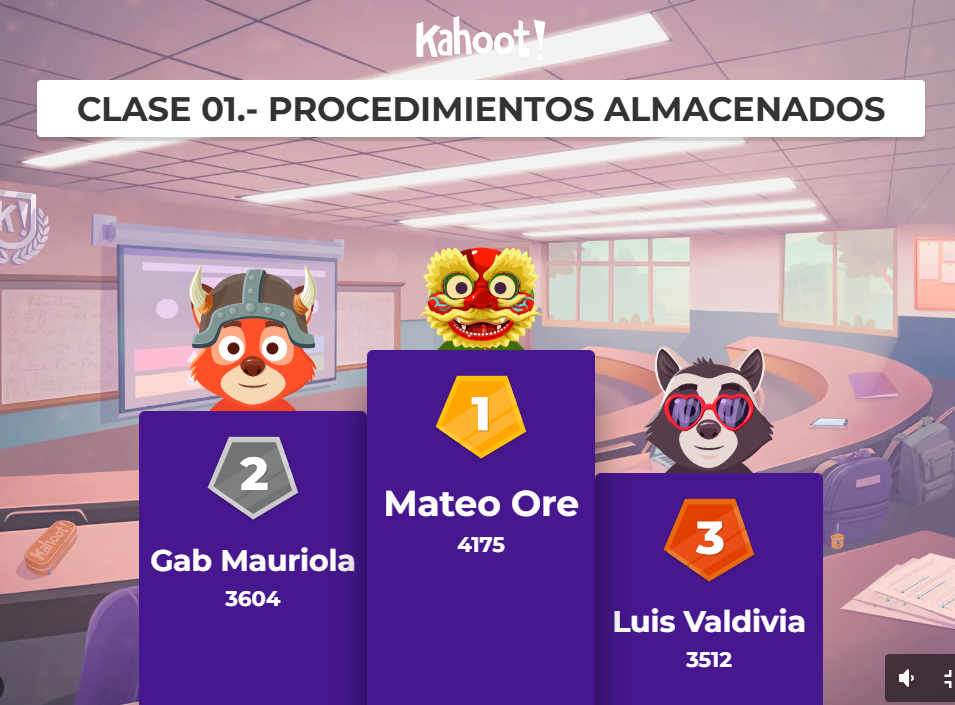